(target-dj-compute-behav-bouts)=
# DataJoint pipeline: Computing behavioural bouts

:::{important}
This guide assumes you have a [DataJoint pipeline deployed](target-dj-pipeline-deployment) with [data already ingested](target-dj-data-ingestion-processing).
:::

Using position data from the [Aeon DataJoint pipeline](target-aeon-dj-pipeline), this guide walks through computing **sleep**, **drink**, and **explore** bouts for each subject in a multi-animal setup.

You can also run this notebook online at [`works.datajoint.com`](https://works.datajoint.com/) using the following credentials:
 - Username: aeondemo
 - Password: aeon_djworks 

To access it, go to the Notebook tab at the top and in the File Browser on the left, navigate to `ucl-swc_aeon > docs > examples`, where this notebook `dj_compute_bouts.ipynb` is located.

:::{note}
The examples here use the _social_ period of the [social0.2-aeon4](target-full-datasets) dataset.
Since the social period spans 2 weeks, we limit retrieval to the first 24 hours to keep the examples concise.

If you are using a different dataset, be sure to replace the experiment name and parameters in the code below accordingly.
:::

## Import libraries and define variables and helper functions

In [ ]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from aeon.dj_pipeline import acquisition, streams, tracking

In [2]:
def remove_swaps(pos_df: pd.DataFrame, max_speed: float) -> pd.DataFrame:
    """Detect and remove swaps in the position data.

    Args:
        pos_df (pd.DataFrame): DataFrame containing position data of a single subject.
        max_speed (float): Maximum speed (px/s) threshold over which we assume a swap.

    Returns:
        pd.DataFrame: DataFrame with swaps removed.
    """
    dt = pos_df.index.diff().total_seconds()
    dx = pos_df["x"].diff()
    dy = pos_df["y"].diff()
    pos_df["inst_speed"] = np.sqrt(dx**2 + dy**2) / dt

    # Identify jumps
    jumps = (pos_df["inst_speed"] > max_speed)
    shift_down = jumps.shift(1)
    shift_down.iloc[0] = False
    shift_up = jumps.shift(-1)
    shift_up.iloc[len(jumps) - 1] = False
    jump_starts = jumps & ~shift_down
    jump_ends = jumps & ~shift_up
    jump_start_indices = np.where(jump_starts)[0]
    jump_end_indices = np.where(jump_ends)[0]

    if np.any(jumps):
        # Ensure the lengths match
        if len(jump_start_indices) > len(jump_end_indices):  # jump-in-progress at start
            jump_end_indices = np.append(jump_end_indices, len(pos_df) - 1)
        elif len(jump_start_indices) < len(jump_end_indices):  # jump-in-progress at end
            jump_start_indices = np.insert(jump_start_indices, 0, 0)
        # Remove jumps by setting speed to nan in jump regions and dropping nans
        for start, end in zip(jump_start_indices, jump_end_indices, strict=True):
            pos_df.loc[pos_df.index[start]:pos_df.index[end], "inst_speed"] = np.nan
        pos_df.dropna(subset=["inst_speed"], inplace=True)

    return pos_df

In [13]:
cm2px = 5.2  # 1 cm = 5.2 px roughly for top camera
light_off, light_on = 7, 20  # 7am to 8pm
nest_center = np.array((1215, 530))
nest_radius = 14 * cm2px  # 14 cm, in px
exp = {
    "name": "social0.2-aeon4",
    "presocial_start": "2024-01-31 11:00:00",
    "presocial_end": "2024-02-08 15:00:00",
    "social_start": "2024-02-09 17:00:00",
    "social_end": "2024-02-23 12:00:00",
    "postsocial_start": "2024-02-25 18:00:00",
    "postsocial_end": "2024-03-02 13:00:00",
}
key = {"experiment_name": exp["name"]}
# Define periods
periods = {
    "presocial": (exp["presocial_start"], exp["presocial_end"]),
    "social": (exp["social_start"], exp["social_end"]),
    "postsocial": (exp["postsocial_start"], exp["postsocial_end"]),
}
# Select the social period and limit to first day for brevity
period_name = "social"
start = periods[period_name][0]
start_dt = datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
end_dt = start_dt + pd.Timedelta(days=1)

## Fetch position data

In [5]:
def load_position_data(
    key: dict[str, str], period_start: str, period_end: str
) -> pd.DataFrame:
    """Loads position data (centroid tracking) for a specified time period.

    Args:
        key (dict): Key to identify experiment data (e.g., {"experiment_name": "Exp1"}).
        period_start (str): Start datetime of the time period.
        period_end (str): End datetime of the time period.

    Returns:
        pd.DataFrame: DataFrame containing position data for the specified period.
                     Returns an empty DataFrame if no data found.
    """
    try:
        print(f"  Querying data from {period_start} to {period_end}...")

        # Create chunk restriction for the time period
        chunk_restriction = acquisition.create_chunk_restriction(
            key["experiment_name"], period_start, period_end
        )

        # Fetch centroid tracking data for the specified period
        centroid_df = (
            streams.SpinnakerVideoSource * tracking.DenoisedTracking.Subject
            & key
            & {"spinnaker_video_source_name": "CameraTop"}
            & chunk_restriction
        ).fetch(format="frame")

        centroid_df = centroid_df.reset_index()
        centroid_df = centroid_df.rename(
            columns={
                "subject_name": "identity_name",
                "timestamps": "time",
                "subject_likelihood": "identity_likelihood",
            }
        )
        centroid_df = centroid_df.explode(
            ["time", "identity_likelihood", "x", "y", "likelihood"]
        )
        centroid_df = centroid_df[
            [
                "time",
                "experiment_name",
                "identity_name",
                "identity_likelihood",
                "x",
                "y",
                "likelihood",
            ]
        ].set_index("time")

        # Clean up the dataframe
        if isinstance(centroid_df, pd.DataFrame) and not centroid_df.empty:
            if "spinnaker_video_source_name" in centroid_df.columns:
                centroid_df.drop(columns=["spinnaker_video_source_name"], inplace=True)
            print(f"  Retrieved {len(centroid_df)} rows of position data")
        else:
            print("  No data found for the specified period")

        return centroid_df

    except Exception as e:
        print(
            f"  Error loading position data for {key['experiment_name']} ({period_start} "
            f"to {period_end}): {e}"
        )
        return pd.DataFrame()


# Load position data
# If this takes too long, consider changing end_dt to an earlier time
position_df = load_position_data(key, start_dt, end_dt).sort_index()

float_cols = ['identity_likelihood', 'x', 'y', 'likelihood']
for col in float_cols:
    position_df[col] = pd.to_numeric(position_df[col], errors='coerce')

  Querying data from 2024-02-09 17:00:00 to 2024-02-10 17:00:00...
  Retrieved 7162981 rows of position data


In [11]:
position_df.head()

,experiment_name,identity_name,identity_likelihood,x,y,likelihood
time,,,,,,
2024-02-09 16:48:10.660,social0.2-aeon4,BAA-1104048,NaN,1280.208496,550.073364,0.971199
2024-02-09 16:48:10.660,social0.2-aeon4,BAA-1104049,0.102343,1232.146240,558.113037,0.971199
2024-02-09 16:48:10.680,social0.2-aeon4,BAA-1104049,0.021459,1282.991699,552.229248,0.985731
2024-02-09 16:48:10.680,social0.2-aeon4,BAA-1104048,NaN,1232.227051,560.120911,0.985731
2024-02-09 16:48:10.700,social0.2-aeon4,BAA-1104048,NaN,1283.058105,552.201538,0.963831


In [ ]:
# Downsample position_df for plotting
position_df_downsampled = (
    position_df.groupby(["identity_name"], group_keys=False)
    .resample("1s")  # 1-second intervals
    .first()
    .dropna(subset=["x", "y"])
)
# Compute time-of-day and flag dark vs light periods
position_df_downsampled["tod"] = (
    position_df_downsampled.index.hour
    + position_df_downsampled.index.minute / 60
    + position_df_downsampled.index.second / 3600
    + position_df_downsampled.index.microsecond / 1e6 / 3600
)
# Detect light/dark transitions and assign period IDs
position_df_downsampled["is_dark"] = (position_df_downsampled["tod"] >= light_off) & (
    position_df_downsampled["tod"] < light_on
)
first_dark = position_df_downsampled.groupby("identity_name")["is_dark"].transform("first")
shifted = position_df_downsampled.groupby("identity_name")["is_dark"].shift().fillna(first_dark)
position_df_downsampled["light_change"] = position_df_downsampled["is_dark"] != shifted
position_df_downsampled["light_id"] = (
    position_df_downsampled.groupby("identity_name")["light_change"].cumsum().astype(int) + 1
)

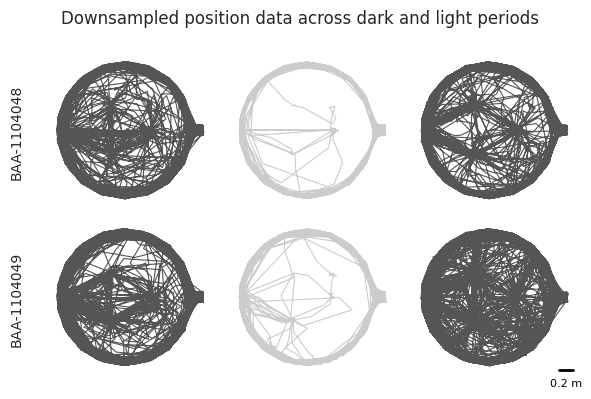

In [62]:
# Setup
dark_color = "#555555"
light_color = "#CCCCCC"
subjects = sorted(position_df_downsampled["identity_name"].unique())
n_subj = len(subjects)
n_per = int(position_df_downsampled["light_id"].max())

# Create subplot grid
fig, axes = plt.subplots(
    nrows=n_subj,
    ncols=n_per,
    figsize=(2 * n_per, 2 * n_subj),
    sharex=True,
    sharey=True,
    squeeze=False,
)

for i, subj in enumerate(subjects):
    for j in range(1, n_per + 1):
        ax = axes[i, j - 1]
        sub = position_df_downsampled[
            (position_df_downsampled.identity_name == subj) & (position_df_downsampled.light_id == j)
        ]
        if sub.empty:
            ax.set_axis_off()
            continue
        col = dark_color if sub.is_dark.iloc[0] else light_color
        ax.plot(sub["x"].values, sub["y"].values, color=col, linewidth=0.8, rasterized=True)
        ax.set_aspect("equal", "box")
        ax.axis("off")
        if j == 1:
            ax.text(
                -0.15, 0.5, subj, transform=ax.transAxes, fontsize=10, va="center", ha="right", rotation=90
            )


# Add scale bar to bottom-right subplot
last_ax = axes[-1, -1]
length_px = 0.2 * 100 * cm2px
xmin, xmax = last_ax.get_xlim()
ymin, ymax = last_ax.get_ylim()
x1 = xmax - 0.02 * (xmax - xmin)
x0 = x1 - length_px
y0 = ymin + 0.02 * (ymax - ymin)

last_ax.plot([x0, x1], [y0, y0], "k-", lw=2)
last_ax.text(
    (x0 + x1) / 2,
    y0 - 0.06 * (ymax - ymin),
    "0.2 m",
    va="top",
    ha="center",
    fontsize=8,
    color="k",
)
fig.suptitle("Downsampled position data across dark and light periods")
plt.tight_layout()
plt.show()

## Sleep bouts

Using position data, we can infer sleep bouts for each subject by identifying sustained periods of low movement:

1. Divide the data into consecutive 1-minute windows.
2. For each window, compute the maximum displacement between the furthest tracked points.
3. Label windows as sleep if displacement falls below a threshold (`move_thresh`, e.g. 4 cm converted to pixels).
4. Merge adjacent sleep windows into continuous sleep bouts.
5. Exclude bouts shorter than 2 minutes.

In [18]:
def sleep_bouts(
    pos_df: pd.DataFrame,
    subject: str,
    move_thresh: float = 4 * cm2px,  # cm -> px
    max_speed: float = 100 * cm2px,  # cm/s -> px/s
) -> pd.DataFrame:
    """Returns sleep bouts for a given animal within the specified position data time period.

    Args:
        pos_df (pd.DataFrame): DataFrame containing position data.
        subject (str): Name of the animal to filter by.
        move_thresh (float): Movement (in px) threshold to define sleep bouts.
        max_speed (float): Maximum speed threshold for excising swaps.

    Returns:
        pd.DataFrame: DataFrame containing sleep bouts for the specified animal.
    """
    animal_data = pos_df[pos_df["identity_name"] == subject].copy()
    if animal_data.empty or not isinstance(animal_data, pd.DataFrame):
        print(f"No position data found for {subject}")
        return pd.DataFrame()

    # Set some constants and placeholder `windows_df` which will be combined into `bouts_df`
    sleep_win = pd.Timedelta("1m")
    sleep_windows_df = pd.DataFrame(
        columns=["subject", "start", "end", "duration"]
    )

    # Create time windows based on start and end time
    data_start_time = animal_data.index.min()
    data_end_time = animal_data.index.max()
    window_starts = pd.date_range(
        start=data_start_time, end=data_end_time, freq=sleep_win
    )

    # <s> Process each time window
    pbar = tqdm(window_starts, desc=f"Processing sleep bouts for {subject} ")
    for win_start in pbar:
        win_end = win_start + sleep_win
        win_data = animal_data[
            (animal_data.index >= win_start) & (animal_data.index < win_end)
        ].copy()
        if len(win_data) < 100:  # skip windows with too little data
            continue

        # Excise id swaps (based on pos / speed jumps)
        # win_data = correct_swaps(win_data, max_speed)

        # Calculate the displacement - maximum distance between any two points in the window
        dx = win_data["x"].max() - win_data["x"].min()
        dy = win_data["y"].max() - win_data["y"].min()
        displacement = np.sqrt(dx**2 + dy**2)

        # If displacement is less than threshold, consider it a sleep bout
        if displacement < move_thresh:
            new_bout = {
                "subject": subject,
                "start": win_start,
                "end": win_end,
                "duration": sleep_win,
            }
            sleep_windows_df = pd.concat(
                [sleep_windows_df, pd.DataFrame([new_bout])], ignore_index=True
            )
    # </s>

    # <s> Now merge consecutive sleep windows into continuous bouts
    if sleep_windows_df.empty or not isinstance(sleep_windows_df, pd.DataFrame):
        return pd.DataFrame(columns=["subject", "start", "end", "duration"])
    # Initialize the merged bouts dataframe with the first window
    sleep_bouts_df = pd.DataFrame(
        [
            {
                "subject": subject,
                "start": sleep_windows_df.iloc[0]["start"],
                "end": sleep_windows_df.iloc[0]["end"],
                "duration": sleep_windows_df.iloc[0]["duration"],
            }
        ]
    )
    # Iterate through remaining windows and merge consecutive ones
    for i in range(1, len(sleep_windows_df)):
        current_window = sleep_windows_df.iloc[i]
        last_bout = sleep_bouts_df.iloc[-1]

        if current_window["start"] == last_bout["end"]:  # continue bout
            sleep_bouts_df.at[len(sleep_bouts_df) - 1, "end"] = current_window["end"]
            sleep_bouts_df.at[len(sleep_bouts_df) - 1, "duration"] = (
                sleep_bouts_df.iloc[-1]["end"] - sleep_bouts_df.iloc[-1]["start"]
            )
        else:  # start a new bout
            new_bout = {
                "subject": subject,
                "start": current_window["start"],
                "end": current_window["end"],
                "duration": current_window["duration"],
            }
            sleep_bouts_df = pd.concat(
                [sleep_bouts_df, pd.DataFrame([new_bout])], ignore_index=True
            )
    # </s>

    # Set min bout time
    min_bout_time = pd.Timedelta("2m")
    sleep_bouts_df = sleep_bouts_df[sleep_bouts_df["duration"] >= min_bout_time]

    return sleep_bouts_df

In [ ]:
# Compute sleep bouts for each subject
subjects = position_df["identity_name"].unique()
sleep_bouts_df = pd.DataFrame(
    columns=["subject", "start", "end", "duration"]
)
for subject in subjects:
    subject_bouts = sleep_bouts(position_df, subject)
    if isinstance(subject_bouts, pd.DataFrame) and not subject_bouts.empty:
        sleep_bouts_df = pd.concat(
            [sleep_bouts_df, subject_bouts], ignore_index=True
        )


In [22]:
sleep_bouts_df

,subject,start,end,duration
0,BAA-1104048,2024-02-09 19:04:10.660,2024-02-09 19:06:10.660,0 days 00:02:00
1,BAA-1104048,2024-02-09 20:27:10.660,2024-02-09 20:29:10.660,0 days 00:02:00
2,BAA-1104048,2024-02-09 21:10:10.660,2024-02-09 21:13:10.660,0 days 00:03:00
3,BAA-1104048,2024-02-09 21:16:10.660,2024-02-09 22:23:10.660,0 days 01:07:00
4,BAA-1104048,2024-02-09 22:28:10.660,2024-02-09 22:33:10.660,0 days 00:05:00
...,...,...,...,...
128,BAA-1104049,2024-02-10 15:12:10.660,2024-02-10 15:15:10.660,0 days 00:03:00
129,BAA-1104049,2024-02-10 15:16:10.660,2024-02-10 15:26:10.660,0 days 00:10:00
130,BAA-1104049,2024-02-10 15:28:10.660,2024-02-10 15:39:10.660,0 days 00:11:00
131,BAA-1104049,2024-02-10 16:06:10.660,2024-02-10 16:08:10.660,0 days 00:02:00


## Drink bouts

We define a drink bout as a period when a subject is:

- Near the water spout: The subject's position is within a set radius (`start_radius`, e.g. 4 cm in pixels) of the spout location.
- Movement is minimal: During the bout, the subject's displacement from the initial position stays below a threshold (`move_thresh`, e.g. 2.5 cm in pixels).
- Duration is within limits: The bout lasts longer than a minimum duration (`min_dur`, e.g. 6 s) and shorter than a maximum duration (`max_dur`, e.g. 90 s).

The bout starts when the subject enters the spout zone and ends when it either moves too much, leaves the zone, or exceeds the maximum duration. Only bouts meeting all criteria are considered.


In [24]:
def drink_bouts(
    pos_df: pd.DataFrame,
    subject: str,
    spout_loc: tuple[float, float],  # x,y spout location in px
    start_radius: float = 4 * 5.2,  # must be within X cm of spout, in px
    move_thresh: float = 2.5 * 5.2,  # during bout must move less than X cm, in px
    min_dur: float = 6,  # min duration of bout in seconds
    max_dur: float = 90,  # max duration of bout in seconds
) -> pd.DataFrame:  # cols: subject, start, end, duration, period
    """Returns drink bouts for a given animal within the specified position data time period."""

    animal_data = pos_df[pos_df["identity_name"] == subject].copy()
    if animal_data.empty or not isinstance(animal_data, pd.DataFrame):
        print(f"No position data found for {subject}")
        return pd.DataFrame(columns=["subject", "start", "end", "duration"])

    # Smooth position data to 100ms intervals - only numeric columns
    numeric_cols = animal_data.select_dtypes(include=[np.number]).columns
    animal_data = animal_data[numeric_cols].resample("100ms").mean().interpolate()
    animal_data = animal_data.dropna()

    # Add non-numeric columns back
    animal_data["identity_name"] = subject
    animal_data["experiment_name"] = pos_df["experiment_name"].iloc[0]

    # Calculate distance from spout
    spout_x, spout_y = spout_loc
    animal_data["dist_to_spout"] = np.sqrt(
        (animal_data["x"] - spout_x) ** 2 + (animal_data["y"] - spout_y) ** 2
    )

    # Find potential bout starts (within start_radius of spout)
    near_spout = animal_data["dist_to_spout"] <= start_radius

    drink_bouts_df = pd.DataFrame(
        columns=["subject", "start", "end", "duration"]
    )

    pbar = tqdm(
        total=len(animal_data), desc=f"Processing drink bouts for {subject}"
    )
    i = 0
    while i < len(animal_data):
        pbar.update(i - (i - 1))
        # Skip if not near spout
        if not near_spout.iloc[i]:
            i += 1
            continue

        # Found potential bout start
        bout_start_time = animal_data.index[i]
        bout_start_idx = i

        # Track movement during potential bout
        start_x = animal_data["x"].iloc[i]
        start_y = animal_data["y"].iloc[i]

        j = i
        max_displacement = 0

        # Continue while near spout and not moving too much
        while j < len(animal_data):
            current_time = animal_data.index[j]
            elapsed_time = (current_time - bout_start_time).total_seconds()

            # Calculate displacement from bout start position
            current_x = animal_data["x"].iloc[j]
            current_y = animal_data["y"].iloc[j]
            displacement = np.sqrt(
                (current_x - start_x) ** 2 + (current_y - start_y) ** 2
            )
            max_displacement = max(max_displacement, displacement)

            # Check if bout should end
            if max_displacement > move_thresh:
                break

            if elapsed_time > max_dur:
                break

            j += 1

        # Determine bout end
        bout_end_time = (
            animal_data.index[j - 1] if j > bout_start_idx else bout_start_time
        )
        bout_duration = (bout_end_time - bout_start_time).total_seconds()

        # Check if bout meets duration criteria
        if min_dur < bout_duration < max_dur:
            new_bout = {
                "subject": subject,
                "start": bout_start_time,
                "end": bout_end_time,
                "duration": pd.Timedelta(seconds=bout_duration),
            }
            drink_bouts_df = pd.concat(
                [drink_bouts_df, pd.DataFrame([new_bout])], ignore_index=True
            )

        # Move to next potential bout (skip past current bout end)
        i = max(j, i + 1)

    pbar.close()
    return drink_bouts_df

In [ ]:
# Compute drink bouts for each subject
subjects = position_df["identity_name"].unique()
drink_bouts_df = pd.DataFrame(
    columns=["subject", "start", "end", "duration"]
)
for subject in subjects:
    spout_loc = (1280, 500) if "aeon3" in exp["name"] else (1245, 535)
    subject_bouts = drink_bouts(position_df, subject, spout_loc)
    if isinstance(subject_bouts, pd.DataFrame) and not subject_bouts.empty:
        drink_bouts_df = pd.concat(
            [drink_bouts_df, subject_bouts], ignore_index=True
        )

In [39]:
drink_bouts_df

,subject,start,end,duration
0,BAA-1104048,2024-02-09 16:53:55.400,2024-02-09 16:54:02.300,0 days 00:00:06.900000
1,BAA-1104048,2024-02-09 17:08:33.300,2024-02-09 17:08:44.100,0 days 00:00:10.800000
2,BAA-1104048,2024-02-09 17:08:44.200,2024-02-09 17:08:50.400,0 days 00:00:06.200000
3,BAA-1104048,2024-02-09 17:15:14.000,2024-02-09 17:15:24.700,0 days 00:00:10.700000
4,BAA-1104048,2024-02-09 17:43:53.900,2024-02-09 17:44:03.800,0 days 00:00:09.900000
...,...,...,...,...
213,BAA-1104049,2024-02-10 17:26:44.400,2024-02-10 17:27:22.100,0 days 00:00:37.700000
214,BAA-1104049,2024-02-10 17:34:49.400,2024-02-10 17:35:19.800,0 days 00:00:30.400000
215,BAA-1104049,2024-02-10 17:40:56.100,2024-02-10 17:41:38.900,0 days 00:00:42.800000
216,BAA-1104049,2024-02-10 17:41:51.700,2024-02-10 17:42:34.100,0 days 00:00:42.400000


## Explore bouts

We define an explore bout as a period when a subject is:

- Outside the nest area: More than 50% of tracked positions in a 1-minute window fall outside a defined nest radius (`nest_radius`) from the nest center (`nest_center`).
- Actively moving: The subject is not stationary and shows exploratory displacement across the window.
- Sustained over time: Consecutive windows meeting the above criteria are merged into continuous bouts lasting at least 1 minute.

The bout begins when the subject exits the nest area and continues as long as it remains outside and actively moving. 
Consecutive windows marked as explore bouts are merged into longer continuous bouts.

In [42]:
# Given pos_df, animal name, nest xy, return all exploration bouts in df
def explore_bouts(
    pos_df: pd.DataFrame,
    subject: str,
    nest_center: np.ndarray,
    nest_radius: float = 14 * 5.2,  # 14 cm, in px
    max_speed: float = 100 * 5.2,  # 100 cm/s, in px/s
) -> pd.DataFrame:
    """Returns exploration bouts for a given animal within the specified position data time period.

    Args:
        pos_df (pd.DataFrame): DataFrame containing position data.
        subject (str): Name of the animal to filter by.
        nest_center (np.ndarray): Coordinates of the nest center.
        nest_radius (float): Radius of the nest area (default: 14 cm in px).
        max_speed (float): Maximum speed threshold for excising swaps (default: 100 cm/s in px/s).

    Returns:
        pd.DataFrame: DataFrame containing exploration bouts for the specified animal.
    """
    animal_data = pos_df[pos_df["identity_name"] == subject].copy()
    if animal_data.empty or not isinstance(animal_data, pd.DataFrame):
        print(f"No position data found for {subject}")
        return pd.DataFrame()

    # Set some constants and placeholder `windows_df` which will be combined into `bouts_df`
    explore_win = pd.Timedelta("1m")
    explore_windows_df = pd.DataFrame(
        columns=["subject", "start", "end", "duration"]
    )

    # Create time windows based on start and end time
    data_start_time = animal_data.index.min()
    data_end_time = animal_data.index.max()
    window_starts = pd.date_range(
        start=data_start_time, end=data_end_time, freq=explore_win
    )

    # Process each time window (use tqdm for progress bar)
    pbar = tqdm(window_starts, desc=f"Processing explore bouts for {subject}")
    for win_start in pbar:
        win_end = win_start + explore_win
        win_data = animal_data[
            (animal_data.index >= win_start) & (animal_data.index < win_end)
        ].copy()
        if len(win_data) < 100:  # skip windows with too little data
            continue

        # Remove id swaps (based on pos / speed jumps)
        win_data = remove_swaps(win_data, max_speed)

        # If majority of time in a window is outside nest, consider it an explore bout
        dx = win_data["x"] - nest_center[0]
        dy = win_data["y"] - nest_center[1]
        distance_from_nest = np.sqrt(dx**2 + dy**2)
        frac_out_nest = (distance_from_nest > nest_radius).sum() / len(win_data)
        if frac_out_nest > 0.5:
            new_bout = {
                "subject": subject,
                "start": win_start,
                "end": win_end,
                "duration": explore_win,
            }
            explore_windows_df = pd.concat(
                [explore_windows_df, pd.DataFrame([new_bout])], ignore_index=True
            )
    
    # Merge consecutive explore windows into continuous bouts
    if explore_windows_df.empty or not isinstance(explore_windows_df, pd.DataFrame):
        return pd.DataFrame(columns=["subject", "start", "end", "duration"])
    # Initialize the merged bouts dataframe with the first window
    explore_bouts_df = pd.DataFrame(
        [
            {
                "subject": subject,
                "start": explore_windows_df.iloc[0]["start"],
                "end": explore_windows_df.iloc[0]["end"],
                "duration": explore_windows_df.iloc[0]["duration"],
            }
        ]
    )
    # Iterate through remaining windows and merge consecutive ones
    for i in range(1, len(explore_windows_df)):
        current_window = explore_windows_df.iloc[i]
        last_bout = explore_bouts_df.iloc[-1]

        if current_window["start"] == last_bout["end"]:  # continue bout
            explore_bouts_df.at[len(explore_bouts_df) - 1, "end"] = current_window["end"]
            explore_bouts_df.at[len(explore_bouts_df) - 1, "duration"] = (
                explore_bouts_df.iloc[-1]["end"] - explore_bouts_df.iloc[-1]["start"]
            )
        else:  # start a new bout
            new_bout = {
                "subject": subject,
                "start": current_window["start"],
                "end": current_window["end"],
                "duration": current_window["duration"],
            }
            explore_bouts_df = pd.concat(
                [explore_bouts_df, pd.DataFrame([new_bout])], ignore_index=True
            )

    return explore_bouts_df

In [ ]:
subjects = position_df["identity_name"].unique()
explore_bouts_df = pd.DataFrame(
    columns=["subject", "start", "end", "duration"]
)
for subject in subjects:
    subject_bouts = explore_bouts(position_df, subject, nest_center)
    if isinstance(subject_bouts, pd.DataFrame) and not subject_bouts.empty:
        explore_bouts_df = pd.concat(
            [explore_bouts_df, subject_bouts], ignore_index=True
        )

In [45]:
explore_bouts_df

,subject,start,end,duration
0,BAA-1104048,2024-02-09 16:48:10.660,2024-02-09 16:53:10.660,0 days 00:05:00
1,BAA-1104048,2024-02-09 16:54:10.660,2024-02-09 17:08:10.660,0 days 00:14:00
2,BAA-1104048,2024-02-09 17:09:10.660,2024-02-09 17:27:10.660,0 days 00:18:00
3,BAA-1104048,2024-02-09 17:29:10.660,2024-02-09 17:43:10.660,0 days 00:14:00
4,BAA-1104048,2024-02-09 17:44:10.660,2024-02-09 17:53:10.660,0 days 00:09:00
...,...,...,...,...
131,BAA-1104049,2024-02-10 17:03:10.660,2024-02-10 17:09:10.660,0 days 00:06:00
132,BAA-1104049,2024-02-10 17:17:10.660,2024-02-10 17:26:10.660,0 days 00:09:00
133,BAA-1104049,2024-02-10 17:28:10.660,2024-02-10 17:34:10.660,0 days 00:06:00
134,BAA-1104049,2024-02-10 17:35:10.660,2024-02-10 17:41:10.660,0 days 00:06:00
